# Capstone Project: Airline Departure Delays
## Notebook III (Modeling)


Author: Julie Vovchenko

---

## Table of Content:
- [Feature Engineering](#Feature-Engineering)
    - [Prior Flight Information](#Prior-Flight-Information)
        - [Same Day Flight Count](#Same-Day-Flight-Count)
        - [Same Day Prior Origin, Delay, Hour](#Same-Day-Prior-Origin,-Delay,-Hour)
    - [Cyclical-Features](#Cyclical-Features)
    - [Features Summary](#Features-Summary)
    - [Interactions](#Interactions)
    - [Dummy Variables](#Dummy-Variables)
- [Modeling](#Modeling)
    - [Baseline Model](#Baseline-Model)
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest](#Random-Forest)
    - [AdaBoost](#AdaBoost)
    - [Gaussian Naive Bayes](#Gaussian-Naive-Bayes)
    - [Feed Forward Neural Network](#Feed-Forward-Neural-Network)
-  [Model Selection](#Model-Selection)     
    -  [Confusion Matrix](#Confusion-Matrix)     
    -  [Precision-Recall Curve](#Precision-Recall-Curve)     
    -  [Coefficients](#Coefficients)  
-  [Conclusion and Recommendations](#Conclusion-and-Recommendations) 
-  [Next Steps](#Next-Steps) 
-  [References](#References)

## Dataset

- [Cleaned Data for 2018(Final)](../data/2018_reporting_clean_final.csv)

In [1]:
# Import our libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, time, pickle

# Import from sklearn.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow
from tensorflow.keras.metrics import AUC



%matplotlib inline

Using TensorFlow backend.


In [2]:
# Reading Carrier On-Time Performance Statistic table for 2018
df = pd.read_csv('../data/2018_reporting_clean_final.csv')
df.shape

(7096846, 56)

In [3]:
# Viewing first five rows of the dataframe
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,ARR_TIME_BLK,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,DISTANCE_GROUP,DIV_AIRPORT_LANDINGS,CRS_DEP_TIME_HR,CRS_ARR_TIME_HR
0,2018,1,1,27,6,2018-01-27,UA,19977,UA,N26232,...,0800-0859,0.0,173.0,174.0,148.0,966.0,4,0.0,6,8
1,2018,1,1,27,6,2018-01-27,UA,19977,UA,N477UA,...,0800-0859,0.0,133.0,119.0,98.0,679.0,3,0.0,6,8
2,2018,1,1,27,6,2018-01-27,UA,19977,UA,N13720,...,1100-1159,0.0,217.0,220.0,190.0,1208.0,5,0.0,8,11
3,2018,1,1,27,6,2018-01-27,UA,19977,UA,N16217,...,1200-1259,0.0,240.0,241.0,212.0,1744.0,7,0.0,6,12
4,2018,1,1,27,6,2018-01-27,UA,19977,UA,N33714,...,2000-2059,0.0,141.0,131.0,112.0,820.0,4,0.0,18,20


## Feature Engineering

### Prior Flight Information

In order to predict whether the flight will be delayed or not, we cannot use any future information about that flight, including actual arrival time, actual time in the air, taxi in or taxi out. But we can retrieve any past history of that plane for that day. We will first calculate how many trips this plane made on that day. Second, we decided to retrieve origin airport and departure hour from previous flight and whether the previous flight departure was delayed.

#### Same Day Flight Count

In [4]:
## Sort dataframe by date and hour of flight (chronologically)
df = df.sort_values(by = ['FL_DATE', 'CRS_DEP_TIME_HR']).reset_index(drop = True)
## Count how many flights a specific plane has made at each point every day
df['FLIGHT_COUNT'] = df.groupby(['TAIL_NUM','FL_DATE']).cumcount()+1

df['FLIGHT_COUNT'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

**Observation:**  
Total number of flights per day for a plane ranges from 1 to 15. Most amount of flights happen for those planes that take short trips. We noticed high volume of short trips in Alaska.

#### Same Day Prior Origin, Delay, Hour

In [5]:
# Function calculated specific information for a privious flight
# Function takes dataframe, name of the prior feature we are looking on previous flight,
# name of the column that we want to store prior information to,
# and a value that we want to fill in for those flights that have no prior history on that day
# and returns an array of previous flight information
def get_prior_info(df, column, name, replace_null):
    # First we need to sort our dataframe by plane's tail number and then by flight date
    df = df.sort_values(by = ['TAIL_NUM', 'FL_DATE']).reset_index(drop = True)
    # Shifting dataframe to one row for all planes who have more than one flight that day 
    df[name] = df.loc[df['FLIGHT_COUNT'].shift(-1)>1, column]
    df[name] = df[name].shift()
    # To avoid null values, we fill first flights of the day with either 0 or "none"
    df[name] = df[name].fillna(value=replace_null)
    return df

In [6]:
# Retrieving origin airport name for prior flights,
# if this is the first flight of the day we input 'None' instead
df = get_prior_info(df, 'ORIGIN', 'PRIOR_ORIGIN', replace_null='None')
# Same for prior flight: departure hour, and if the departure was delayed or not
df = get_prior_info(df, 'DEP_DEL15', 'PRIOR_DELAY', replace_null=0)
df = get_prior_info(df, 'CRS_DEP_TIME_HR', 'PRIOR_DEP_HR', replace_null=0)

In [7]:
# Checking our work on retrieving on prior information
df[(df['MONTH'] == 1) 
            & (df['DAY_OF_MONTH'] == 2)
            & (df['TAIL_NUM'] == 'N26232')].sort_values('DEP_TIME')[['TAIL_NUM',
                                                                            'FL_DATE',
                                                                              'FLIGHT_COUNT',
                                                                              'ORIGIN',
                                                                              'PRIOR_ORIGIN',
                                                                              'DEP_DEL15',
                                                                              'PRIOR_DELAY',
                                                                              'CRS_DEP_TIME_HR',
                                                                              'PRIOR_DEP_HR' 
                                                                            ]]

,TAIL_NUM,FL_DATE,FLIGHT_COUNT,ORIGIN,PRIOR_ORIGIN,DEP_DEL15,PRIOR_DELAY,CRS_DEP_TIME_HR,PRIOR_DEP_HR
1141158,N26232,2018-01-02,1,DCA,None,0.0,0.0,5,0.0
1141159,N26232,2018-01-02,2,IAH,DCA,1.0,0.0,16,5.0
1141160,N26232,2018-01-02,3,SAT,IAH,0.0,1.0,18,16.0
1141161,N26232,2018-01-02,4,IAH,SAT,1.0,0.0,20,18.0


### Cyclical Features

Credit to [Christopher Dossman](https://medium.com/ai%C2%B3-theory-practice-business/top-6-errors-novice-machine-learning-engineers-make-e82273d394db), we learned that hours of a day, days of a week, months in a year are some examples of features that are cyclical. We need to convert these features into format that machine understands: that 0 hour follows 23 hour.  
We are going to calculate the sin and cos component of that feature, so machine can interpret our feature as cyclical feature as (x,y) coordinates of a circle. This way, Monday and Sunday, January and December, or 23 hour and 0 hour are next to each other numerically.  
If we keep the feature raw, machine wont be able to use the feature properly.  
The other benefit of the transformation is that we can see the correlation of these cyclical features to our target. 

In [8]:
# Transforming our cyclical features to sine and cosine transformation
# DEPARTURE HOURS
df['CRS_DEP_HR_sin'] = np.sin(df.CRS_DEP_TIME_HR*(2.*np.pi/24))
df['CRS_DEP_HR_cos'] = np.cos(df.CRS_DEP_TIME_HR*(2.*np.pi/24))
# ARRIVAL HOURS
df['CRS_ARR_HR_sin'] = np.sin(df.CRS_ARR_TIME_HR*(2.*np.pi/24))
df['CRS_ARR_HR_cos'] = np.cos(df.CRS_ARR_TIME_HR*(2.*np.pi/24))
# PRIOR DEPARTURE HOURS
df['PRIOR_DEP_HR_sin'] = np.sin(df.PRIOR_DEP_HR*(2.*np.pi/24))
df['PRIOR_DEP_HR_cos'] = np.cos(df.PRIOR_DEP_HR*(2.*np.pi/24))

# MONTHS
df['MONTH_sin'] = np.sin((df.MONTH-1)*(2.*np.pi/12))
df['MONTH_cos'] = np.cos((df.MONTH-1)*(2.*np.pi/12))

# DAY OF WEEK
df['DAY_OF_WEEK_sin'] = np.sin((df.DAY_OF_WEEK-1)*(2.*np.pi/7))
df['DAY_OF_WEEK_cos'] = np.cos((df.DAY_OF_WEEK-1)*(2.*np.pi/7))

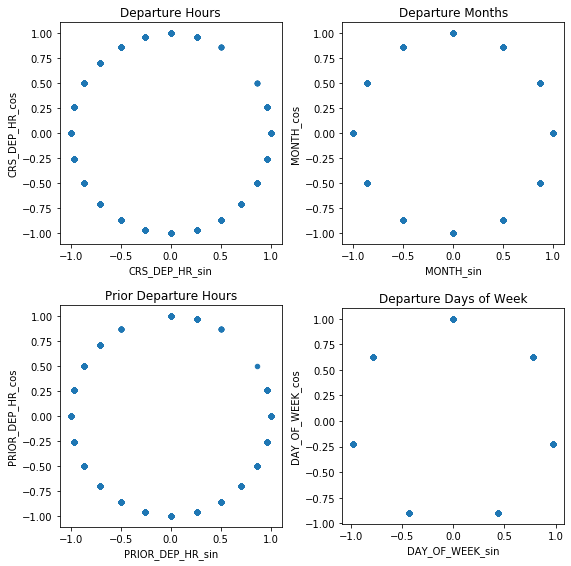

In [9]:
# Visualizing all cyclical features conversions for first 500,000 rows
fig, ax = plt.subplots(2,2, figsize=(8,8))  # 2 row, 2 columns
# Scheduled Departure Hour
df[:500_000].plot.scatter('CRS_DEP_HR_sin','CRS_DEP_HR_cos',
                          ax=ax[0,0]).set_aspect('equal');
# Month
df[:500_000].plot.scatter('MONTH_sin','MONTH_cos', 
                          ax=ax[0,1]).set_aspect('equal');
# Prior Departure Hour
df[:500_000].plot.scatter('PRIOR_DEP_HR_sin','PRIOR_DEP_HR_cos', 
                          ax=ax[1,0]).set_aspect('equal');
# Day Of a Week
df[:500_000].plot.scatter('DAY_OF_WEEK_sin','DAY_OF_WEEK_cos', 
                          ax=ax[1,1]).set_aspect('equal');

plt.tight_layout()
ax[0,0].title.set_text('Departure Hours')
ax[0,1].title.set_text('Departure Months')
ax[1,0].title.set_text('Prior Departure Hours')
ax[1,1].title.set_text('Departure Days of Week')

#### Features Summary
We deal with three types of features in this project: cyclical, ordinal and additional features. Since we handle them differently we have to separate them into three different category. 

In [10]:
# Defining all our features prior to modeling 
cyclical_features = ['CRS_DEP_HR_sin', 'CRS_DEP_HR_cos', # Scheduled Departure Hours
                     'CRS_ARR_HR_sin', 'CRS_ARR_HR_cos', # Scheduled Arrival Hours
                     'MONTH_sin', 'MONTH_cos', # Month of the flight
                    'PRIOR_DEP_HR_sin', 'PRIOR_DEP_HR_cos', # Prior Departure Hour
                    'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'] #Day of Week

# Ordinal features would need to be dummified 
ordinal_features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
                    'PRIOR_ORIGIN']

additional_features = ['FLIGHT_COUNT', 'PRIOR_DELAY',
                       'CRS_ELAPSED_TIME']

# Gathering all important features together modeling
df = df[cyclical_features +  ordinal_features + 
                 additional_features + ['DEP_DEL15']]


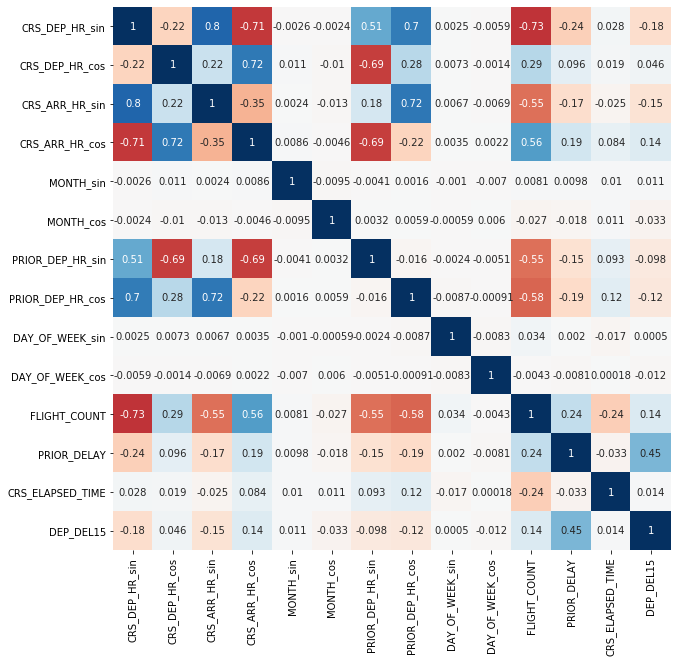

In [11]:
# Checking multicollinearity via heatmap
# (two or more explanatory variables in a multiple regression model 
# are highly linearly related) 
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), 
            cmap='RdBu', #color of the map (red/blue)
            vmin=-1, #Values to anchor the colormap are from -1 to 1
            vmax=1,
            annot=True, #writing the data value in each cell
           cbar=False); #no colorbar drawing

**Observation:**   
There are no multicollinearity between features. Strong correlation are between sine and cosine, which is expected by nature.

#### Interactions
Before creating interactions we want to see those features with highest correlation to our target variable(delayed or not).

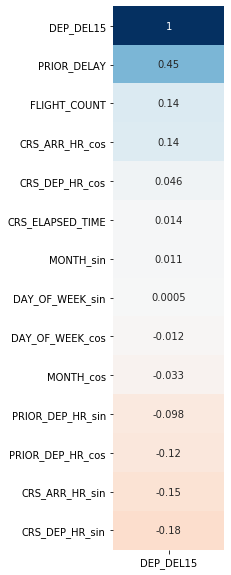

In [12]:
# Plotting the heatmap for correlations of all features to target
plt.figure(figsize=(2, 10))
sns.heatmap(df.corr()[['DEP_DEL15']].sort_values('DEP_DEL15', ascending=False), 
            cmap='RdBu', #color of the map (red/blue)
            vmin=-1, #Values to anchor the colormap are from -1 to 1
            vmax=1,
            annot=True, #writing the data value in each cell
           cbar=False); #no colorbar drawing


In [13]:
# Engineering interaction features from those that have highest correlation to target
df['PRIOR_DELAY*FLIGHT_COUNT']= df['PRIOR_DELAY']*df['FLIGHT_COUNT']
df['PRIOR_DELAY*CRS_ARR_HR_cos']= df['PRIOR_DELAY']*df['CRS_ARR_HR_cos']
df['PRIOR_DELAY*CRS_DEP_HR_sin']= df['PRIOR_DELAY']*df['CRS_DEP_HR_sin']
df['FLIGHT_COUNT*CRS_DEP_HR_sin']= df['FLIGHT_COUNT']*df['CRS_DEP_HR_sin']

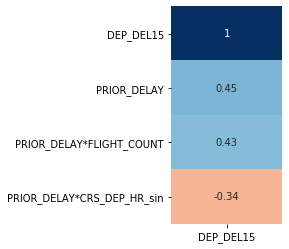

In [14]:
# Plotting heatmap of those features with maximum correlation to target
correlation = df.corr()[['DEP_DEL15']].sort_values('DEP_DEL15', ascending=False)
plt.figure(figsize=(2, 4))
sns.heatmap(correlation[np.abs(correlation['DEP_DEL15'])> 0.3], 
            cmap='RdBu', #color of the map (red/blue)
            vmin=-1, #Values to anchor the colormap are from -1 to 1
            vmax=1,
            annot=True, #writing the data value in each cell
           cbar=False); #no colorbar drawing

In [15]:
# Choosing the top interactions that might help our models
top_interactions = ['PRIOR_DELAY*FLIGHT_COUNT', 
                    'PRIOR_DELAY*CRS_DEP_HR_sin']

In [16]:
df.head()

,CRS_DEP_HR_sin,CRS_DEP_HR_cos,CRS_ARR_HR_sin,CRS_ARR_HR_cos,MONTH_sin,MONTH_cos,PRIOR_DEP_HR_sin,PRIOR_DEP_HR_cos,DAY_OF_WEEK_sin,DAY_OF_WEEK_cos,...,DEST,PRIOR_ORIGIN,FLIGHT_COUNT,PRIOR_DELAY,CRS_ELAPSED_TIME,DEP_DEL15,PRIOR_DELAY*FLIGHT_COUNT,PRIOR_DELAY*CRS_ARR_HR_cos,PRIOR_DELAY*CRS_DEP_HR_sin,FLIGHT_COUNT*CRS_DEP_HR_sin
0,1.000000e+00,6.123234e-17,0.965926,-0.258819,0.0,1.0,0.000000e+00,1.000000e+00,0.0,1.0,...,MEM,None,1,0.0,153.0,0.0,0.0,-0.000000,0.000000,1.000000e+00
1,8.660254e-01,-5.000000e-01,0.258819,-0.965926,0.0,1.0,1.000000e+00,6.123234e-17,0.0,1.0,...,FLL,FLL,2,0.0,136.0,0.0,0.0,-0.000000,0.000000,1.732051e+00
2,1.224647e-16,-1.000000e+00,-0.500000,-0.866025,0.0,1.0,8.660254e-01,-5.000000e-01,0.0,1.0,...,GSP,MEM,3,0.0,112.0,1.0,0.0,-0.000000,0.000000,3.673940e-16
3,-7.071068e-01,-7.071068e-01,-0.866025,-0.500000,0.0,1.0,1.224647e-16,-1.000000e+00,0.0,1.0,...,FLL,FLL,4,1.0,109.0,1.0,4.0,-0.500000,-0.707107,-2.828427e+00
4,-9.659258e-01,-2.588190e-01,-0.965926,0.258819,0.0,1.0,-7.071068e-01,-7.071068e-01,0.0,1.0,...,ORF,GSP,5,1.0,125.0,1.0,5.0,0.258819,-0.965926,-4.829629e+00


In [17]:
print(f"Number of Carriers: {len(df['OP_UNIQUE_CARRIER'].unique())}")
print(f"Number of Origin Airports: {len(df['ORIGIN'].unique())}")
print(f"Number of Destination Airports: {len(df['DEST'].unique())}")
print(f"Number of Prior Airports: {len(df['PRIOR_ORIGIN'].unique())}")

Number of Carriers: 18
Number of Origin Airports: 358
Number of Destination Airports: 358
Number of Prior Airports: 358


#### Label Encoder

In [18]:
# source:
# https://medium.com/@contactsunny/label-encoder-vs-one-hot-encoder-in-machine-learning-3fc273365621
label = LabelEncoder()

df["OP_UNIQUE_CARRIER"] = label.fit_transform(df["OP_UNIQUE_CARRIER"])
df["ORIGIN"] = label.fit_transform(df["ORIGIN"])
df["DEST"] = label.fit_transform(df["DEST"])
df["PRIOR_ORIGIN"] = label.fit_transform(df["PRIOR_ORIGIN"])


In [19]:
# Concatenating all features together for modeling
features = cyclical_features + ordinal_features +\
                additional_features  + top_interactions

print(f'Size of dataframe including dummie variables: {df.shape}')
print(f'Count of all features: {len(features)}')

Size of dataframe including dummie variables: (7096846, 22)
Count of all features: 19


In [20]:
df.shape

(7096846, 22)

For practical reasons, we save our final dataframe with all features, including engineered features, prior to modeling.  This way we may simply use preprocessed dataset that is ready for modeling at any time. 

In [21]:
df.to_csv('../data/2018_reporting_to_model.csv', index = False)

In [2]:
# Opening preprocessed data set for future models
# Please run all library imports first prior to reading the file,
# if dont need to rerun the top half of the notebook
df = pd.read_csv('../data/2018_reporting_to_model.csv')
df.shape

(7096846, 22)

In [3]:
# We are running this cell only if reading the 2018_reporting_to_model.csv file
# Defining all our features prior to modeling 
cyclical_features = ['CRS_DEP_HR_sin', 'CRS_DEP_HR_cos', # Scheduled Departure Hours
                     'CRS_ARR_HR_sin', 'CRS_ARR_HR_cos', # Scheduled Arrival Hours
                     'MONTH_sin', 'MONTH_cos', # Month of the flight
                    'PRIOR_DEP_HR_sin', 'PRIOR_DEP_HR_cos', # Prior Departure Hour
                    'DAY_OF_WEEK_sin', 'DAY_OF_WEEK_cos'] #Day of Week

# Ordinal features would need to be dummified 
ordinal_features = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST',
                    'PRIOR_ORIGIN']

additional_features = ['FLIGHT_COUNT', 'PRIOR_DELAY',
                       'CRS_ELAPSED_TIME']
# Choosing the top interactions that might help our models
top_interactions = ['PRIOR_DELAY*FLIGHT_COUNT', 
                    'PRIOR_DELAY*CRS_DEP_HR_sin']

features = cyclical_features + ordinal_features +\
                additional_features  + top_interactions

### Modeling

#### Baseline Model

In [4]:
# Defining X and y before train-test-split
X = df[features]
y = df['DEP_DEL15']

# Check how dataframe is balanced
y.value_counts(normalize=True)

0.0    0.816227
1.0    0.183773
Name: DEP_DEL15, dtype: float64

By establishing our baseline, we want to compare our future complex models to it. 
Our classes are unbalanced (82/18), so the **baseline model for average precision score is 18% for train and test**.

A baseline is the result of a very basic model, so we are going to create a more complex solutions in order to optimize precision and recall. In our situation, classification problem, we would like to use the following models:  
1. Logistic Regression
2. Random Forest
3. AdaBoost
4. Feed Forward Neural Network

Then, we will define the best model based on average precision scores, that summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold.

In [5]:
# Splitting the data, where test data is 25% of the whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size = 0.25,
                                                    random_state=42)

In [6]:
# Standardise data before modeling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
def run_model(X_train, y_train, pipe, pipe_params):
    # Start our timer.
    t0 = datetime.datetime.now()

    # Instantiate GridSearchCV
    gs = GridSearchCV(pipe, pipe_params, cv = 5,
                      n_jobs = -1, # parallel computing facilities
                      scoring = 'average_precision', 
                      # https://jaquesgrobler.github.io/online-sklearn-build/modules/model_evaluation.html
                     verbose = 1) 
    
    #fiting our X and y train on GridSearchCV with above mentioned paramenters
    #setting time to see how long it takes the fit to run
    gs.fit(X_train, y_train);
    
    # Stop our timer and print the result.
    print(f'Running time: {datetime.datetime.now() - t0}')
    
    print(f'Best Pipeline Score: {gs.best_score_}')
    print(f'Best Params:\n{gs.best_params_}')
    # Extracting the best model from the pipeline
    gs_best = gs.best_estimator_
    # Calculating average precision score for X_train
    probs_train = gs_best.predict_proba(X_train)
    probs_train = probs_train[:, 1]
    apc_train = average_precision_score(y_train, probs_train)
    # Calculating average precision score for X_test
    probs_test = gs_best.predict_proba(X_test)
    probs_test = probs_test[:, 1]
    apc_test = average_precision_score(y_test, probs_test)
    
    print(f'Train Average Precision Score:{apc_train}')
    print(f'Test Average Precision Score:{apc_test}')
    
    # Calculate predictions and show confusion matrix
    preds = gs_best.predict(X_test)
    con_matrix = confusion_matrix(y_test, preds)
    print(f'Confusion Matrix:\n{con_matrix}')
    
    return gs_best, preds

In [23]:
# Creating the function that plots our confusion matrix
def plot_matrix(con_matrix, model_name):
    # Plotting our confusion matrix for better view
    # credit to the following source on putting group_names and counts together inside heatmap:
    # https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    con_matrix.flatten()]
    # label design - names first, counts below
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_names,group_counts)]

    # reshaping the labels to fit each cell
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap((con_matrix), 
                annot=labels,
                annot_kws={"size": 25}, #writing the data value in each cell, big enough to be visible in the presentation
                cmap='Blues', #color of the map (blue)
                fmt="", #format of annotations (no format)
                xticklabels=True, #removing xtickslabels
                yticklabels=True, #removing ytickslabels
                cbar=False); #no colorbar drawing

    #Setting the title to size 27
    plt.title (f'Confusion Matrix for\n {model_name}\n', 
               size=27);
    plt.ylabel('True Label', size=15);
    plt.xlabel('Predicted Label', size=15);
    plt.yticks(size = 15);
    plt.xticks(size = 15);

#### Logistic Regression
Logistic Regression is a classification algorithm that we will use to predict the probability of a discrete variable: delayed(1) or on-time(0).  
For regularization techniques we will try both Lasso (L1) and Ridge (L2). And for inverse of regularization strength (C) we will use 0.1.

In [8]:
# LOGISTIC REGRESSION
# Defining our pipeline
pipe = Pipeline([('lr', LogisticRegression())])
# Hyper Parameters:
pipe_params = {
    'lr__solver': ['liblinear'],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [ 0.1]
}

lr_best_estimator, lr_preds = run_model(X_train, y_train, 
                                           pipe, pipe_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.5min finished


Running time: 0:11:06.818764
Best Pipeline Score: 0.493191679536806
Best Params:
{'lr__C': 0.1, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Train Average Precision Score:0.4932112584675268
Test Average Precision Score:0.49216172852116213
Confusion Matrix:
[[1372427   75732]
 [ 183633  142420]]


#### Random Forest
Random Forest is classification algorithm that consists of n number of trees. It uses bagging and feature randomness to create a set of trees with low correlation to each other. Each tree has an independent 'opinion' of predictions and the final prediction is decided by majority.  
Hyper Parameters:
- We will set the number of trees in the forest to 10,  
- number of features to consider when looking for the best split to set of 9,11 and 13, 
- maximum depth of the tree to set of 11,13 or 15,
- minimum number of samples required to split an internal node and minimum number of samples required to be at a leaf node to 2.


In [9]:
# RANDOM FOREST
pipe = Pipeline([('rf', RandomForestClassifier())])

# Hyper Parameters:
pipe_params = {
    'rf__n_estimators': [20],
    'rf__max_features': [15, 17], # how many features to take (sqrt of total features)
    'rf__max_depth': [20, 22],
    'rf__min_samples_split':[2], 
    'rf__min_samples_leaf':[2], 
    }

rf_best_estimator, rf_preds = run_model(X_train, y_train, 
                                        pipe, pipe_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 314.4min finished


Running time: 5:54:08.552637
Best Pipeline Score: 0.5652398085268476
Best Params:
{'rf__max_depth': 20, 'rf__max_features': 15, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 20}
Train Average Precision Score:0.7111597317681047
Test Average Precision Score:0.5681991784781173
Confusion Matrix:
[[1389845   58314]
 [ 192512  133541]]


#### AdaBoost
Another ensemble method,which takes a weak base learner and tries to make it a strong learner by retraining it on the misclassified samples.  
Hyper Parameters:  
We will set the maximum number of estimators at which boosting is terminated to 30 and learning rate to 0.1 and 0.2.

In [10]:
# ADABOOST MODEL
pipe = Pipeline([('ab', AdaBoostClassifier())])
# Hyper Parameters:
pipe_params = {
    'ab__n_estimators': [30],
    'ab__learning_rate': [0.1, 0.2]
    }

ab_best_estimator, ab_preds = run_model(X_train, y_train, 
                                        pipe, pipe_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 34.5min finished


Running time: 0:43:31.384142
Best Pipeline Score: 0.4855397619997732
Best Params:
{'ab__learning_rate': 0.2, 'ab__n_estimators': 30}
Train Average Precision Score:0.4845619054402086
Test Average Precision Score:0.4826798108153978
Confusion Matrix:
[[1374224   73935]
 [ 185861  140192]]


###### Feedforward Neural Network
We will implement Feedforward Neural Network with only two hidden layers. We will be using 'relu' activation function for input and hidden layers and 'sigmoid' for the output layer, since it is a binary classification problem (0,1). 
In ft.keras metric that we want to optimize called AUC with specific indication 'PR' (=precision_recall).

In [19]:
# FEED FORWARD NEURAL NETWORK
# 
# Instantiate your network
model = Sequential()

# First layer
model.add(Dense(64, # number of nodes in the first hidden layer
               input_shape = (X_train.shape[1],), # the shape of each observation
               activation = 'relu')) 
# Hidden layer 
model.add(Dense(32, activation="relu")) #(power of 2)
# model.add(Dropout(0.20)) #Regularization, to avoid over fitting
model.add(Dense(8, activation="relu")) #(power of 2)
# model.add(Dropout(0.30)) #Regularization, to avoid over fitting
# Output layer.
model.add(Dense(1, activation = 'sigmoid'))

# Compile our model
# Used metric as AUC with specificatin to 'PR'=precision/recall
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
model.compile(loss = 'binary_crossentropy',optimizer = 'adam',
              metrics = [AUC(curve = 'PR')]) # Setting accuracy as metric "auprc"

hist = model.fit(X_train, y_train,  
                 epochs = 10, # number of times we pass each observations through
                 batch_size = 3_000, # sample size passed through
                 validation_data=(X_test, y_test),
                 verbose = 1) # how much progress we are making

Train on 5322634 samples, validate on 1774212 samples
Epoch 1/10
5322634/5322634 [==============================] - 25s 5us/step - loss: 0.3869 - auc: 0.4924 - val_loss: 0.3842 - val_auc: 0.5118
Epoch 2/10
5322634/5322634 [==============================] - 27s 5us/step - loss: 0.3826 - auc: 0.5157 - val_loss: 0.3827 - val_auc: 0.5184
Epoch 3/10
5322634/5322634 [==============================] - 25s 5us/step - loss: 0.3816 - auc: 0.5204 - val_loss: 0.3820 - val_auc: 0.5220
Epoch 4/10
5322634/5322634 [==============================] - 28s 5us/step - loss: 0.3809 - auc: 0.5232 - val_loss: 0.3812 - val_auc: 0.5245
Epoch 5/10
5322634/5322634 [==============================] - 26s 5us/step - loss: 0.3803 - auc: 0.5254 - val_loss: 0.3806 - val_auc: 0.5263
Epoch 6/10
5322634/5322634 [==============================] - 27s 5us/step - loss: 0.3799 - auc: 0.5270 - val_loss: 0.3806 - val_auc: 0.5276
Epoch 7/10
5322634/5322634 [==============================] - 26s 5us/step - loss: 0.3796 - auc: 0.5

In [23]:
# save the models to disk
pickle.dump(lr_best_estimator, open('LogisticRegression.sav', 'wb'))
pickle.dump(rf_best_estimator, open('RandomForest.sav', 'wb'))
pickle.dump(ab_best_estimator, open('AdaBoost.sav', 'wb'))
pickle.dump(model, open('FFNeuralNetwork.sav', 'wb'))

In [7]:
# Load the model from disk
loaded_model = pickle.load(open('RandomForest.sav', 'rb'))
result = loaded_model.score(X_test, y_test)

/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when u

### Model Selection

 Models performance table:   

|   Classifier   | Train Score | Test Score |  |
|------------|------------|-------------|------------|
|      Base Line      | 0.18  | 0.18       |            |
| Logistic Regression | 0.493| 0.492        |        |
|  **Random Forest**  |**0.711** | **0.568**        |       |
|    AdaBoost   |0.485 | 0.483      |      |
|    Feed Forward Neural Network   | 0.530 | 0.531     |       |


Relative to our baseline performance all of our complex models performed with stronger average precision score.  
Based on our models average precision scores we decided to choose Random Forest model as our best model for predictions with strongest Train(0.711) and Test(0.568). The Random Forest model is overfit and requires some further tuning, but we believe that will still perform better than other models. 

#### Confusion Matrix 
Visualizing Confusion Matrix. In this case we are trying to optimize our Average Precision Score by decreasing False Positive.

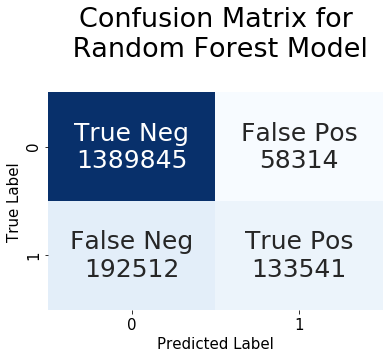

In [24]:
plot_matrix(confusion_matrix(y_test, rf_preds), 'Random Forest Model')

**Observation:**    
Our Random Forest Model has higher average precision score (0.568) than the baseline model, which means that out of all positive predictions our model identified 56% were actually positive. 

#### Precision-Recall Curve
Unlike ROC AUC Curve, **Precision-recall Curve is more appropriate for unbalanced classes.**  

Precision-Recall curve shows the trade-off between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Precision - How accurate the positive predictions are  
Recall/Sensitivity - Coverage of actual positive sample  



/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/juliev/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


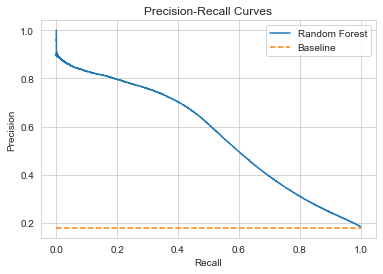

In [12]:
# Plot the precision-recall curves
sns.set_style("whitegrid")
disp = plot_precision_recall_curve(loaded_model, 
                                   X_test, y_test, 
                                   label='Random Forest')
plt.plot([0, 1], [0.18, 0.18], linestyle='--', label='Baseline');
# Labels
plt.title('Precision-Recall Curves')
plt.xlabel('Recall');
plt.ylabel('Precision');
# Show the legend
plt.legend();

#### Coefficients  
We will use Logistic Regression as our interpretive model and Random Forest as predictive model. Therefore, we will be taking coefficients from Logistic Regression to determine which features are the most influential in model prediction decisions for both classes.  

In [148]:
coef_df = pd.DataFrame({
    'column':features,
    'coef':lr_gs_best_estimator.steps[0][1].coef_[0],
    'abs_coef':np.abs(lr_gs_best_estimator.steps[0][1].coef_[0])
})

#Sorting those coefficient by 'coef' columnand viewing top 15
data = coef_df.sort_values(by = 'coef', ascending = False)
# Separating coefficients into two group, above 0 and below 0. 
positive_coefs = coef_df[coef_df['coef']>0].sort_values('coef', 
                                                        ascending = False)


# Getting absolute value of all negative coefficients, for the plot to be 
# more comprehendible 
negative_coefs = coef_df[coef_df['coef']<0]
negative_coefs = negative_coefs.sort_values('abs_coef', ascending =False)

In [149]:
positive_coefs.head()

,column,coef,abs_coef
15,PRIOR_DELAY,0.703760,0.703760
17,PRIOR_DELAY*FLIGHT_COUNT,0.242653,0.242653
7,PRIOR_DEP_HR_cos,0.162426,0.162426
18,PRIOR_DELAY*CRS_DEP_HR_sin,0.121998,0.121998
3,CRS_ARR_HR_cos,0.119001,0.119001


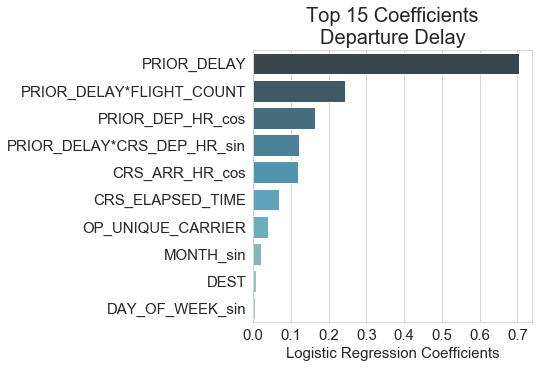

In [159]:
# Visualizing top coefficients of the Linear Regression Model, 
# to pick those that are most effective in predicting
# the correct subreddit
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")

sns.barplot(data=positive_coefs.head(15), 
            x='coef', 
            y='column', 
            palette="GnBu_d") ;

# Setting sise of the title to 20
plt.title ('Top 15 Coefficients\nDeparture Delay', 
           size=20);

# Removing the xlabel and ylabel
plt.ylabel('');
plt.xlabel('Logistic Regression Coefficients', size = 15);
plt.yticks(size = 15);
plt.xticks(size = 15);

In [151]:
negative_coefs.head()

,column,coef,abs_coef
0,CRS_DEP_HR_sin,-0.310432,0.310432
1,CRS_DEP_HR_cos,-0.154202,0.154202
2,CRS_ARR_HR_sin,-0.118651,0.118651
14,FLIGHT_COUNT,-0.107524,0.107524
5,MONTH_cos,-0.087864,0.087864


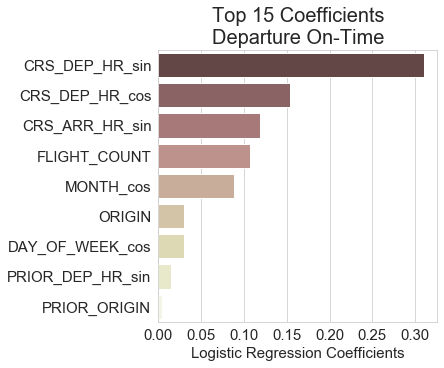

In [158]:
# Visualizing top coefficients of the Linear Regression Model, 
# to pick those that are most effective in predicting
# the correct subreddit
plt.figure(figsize=(5,5))
sns.set_style("whitegrid")

sns.barplot(data=negative_coefs.head(15), 
            x='abs_coef', 
            y='column', 
            palette="pink") ;

# Setting size of the title to 20
plt.title ('Top 15 Coefficients\nDeparture On-Time', 
           size=20);

# Removing the xlabel and ylabel
plt.ylabel('');
plt.xlabel('Logistic Regression Coefficients', size = 15);
plt.yticks(size = 15);
plt.xticks(size = 15);

Since we have only collected a sample, flights for year 2018 the coefficients interpretations are used for generalization of the population (all flights).  

**Coefficient Interpretation:**  
If a flight has a 'PRIOR_DELAY' the log-odds of a flight departure being delayed increases by 70. 
If the flight has prior delay as flight count increases by 1, the log-odds of a flight departure being delayed increases by 24.  
As flight count increases by 1, the log-odds of a flight departure being delayed decreases by 11. 

### Conclusion and Recommendations 
After doing the initial cleanup we were able identify features that are appropriate to use in predicting flight departure delay. Then, we implemented some feature engineering: 
1. We collected information from the prior flight on that day, including same day prior flights count, prior origin and whether the plane had departure delay from previous flight
2. Converted cyclical features into sine and cosine alternatives
3. We also implemented interactions with features with highest correlation to the target.  
4. Ordinal features, e.g. origin and destination airports, were transformed through LabelEncoder, instead of DummyRegressor. It saved us memory space dramatically and predictive models ran much faster. 

Scores of our models are as following: 

|   Classifier   | Train Score | Test Score |  |
|------------|------------|-------------|------------|
|      Base Line      | 0.18  | 0.18       |            |
| Logistic Regression | 0.493| 0.492        |        |
|  **Random Forest**  |**0.711** | **0.568**        |       |
|    AdaBoost   |0.485 | 0.483      |      |
|    Feed Forward Neural Network   | 0.530 | 0.531     |       |

All the models we have trained outperformed the Base Line model. Random Forest had the highest Train and Test average precision score. The scores were 0.711 and 0.5682 on the Train and Test respectfully. Even though our Random Forest model is overfit it performed better than other models we still think there is a scope of improvement. We need to tune it by reducing maximum features and maximum depth of each tree.  

Features that mostly help to identify whether the departure flight be delayed or not, are prior flight departure delays, scheduled departure hour and scheduled arrival hour, along with prior departure hour and prior flight count for the day.

We noticed that our model has limitations. Since we have collected local flights for one year 2018, it only works for local flights and local carriers and it does not take in consideration any economic factors. For example, corona virus outbreak that lead to most flights to be canceled. Other factors that might change over time are (1) airport architectural restructure, that leads to a better internal airport workflow and minimizes departure delays, (2) updating the fleet with newer airplane models that have higher performance rate and require less maintenance.

### Next Steps
According to the [Federal Aviation Administration](https://www.sciencedirect.com/science/article/pii/S2212012218300753), most of the delays in winter are due to surface winds, low ceiling and low visibility, whereas during summer the majority of delays is attributable to convective weather, low ceiling and associated low visibility (Federal Aviation Administration, 2017).  
It will be wise to include daily weather data, like wind speed and precipitation rate, for each origin and destination location for each flight. Here are some resources that can help with that:  
1. [noaa.gov](https://www.ncdc.noaa.gov/cdo-web/)
2. [weather.gov](https://www.weather.gov/help-past-weather)

Additionally, we would also use data about each plane used for the flight. [flightradar24.com](https://www.flightradar24.com/data/aircraft/) website has extensive dataset for almost all planes that are in use by local airlines. This might help to identify those flight delays that occur due manufacture quality or age of the plane. 

## References
www.transtats.bts.gov  
www.noaa.gov  
www.weather.gov  
www.flightradar24.com  
www.faa.gov  
https://medium.com/ai%C2%B3-theory-practice-business/top-6-errors-novice-machine-learning-engineers-make-e82273d394db  